In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

plt.style.use('Solarize_Light2')

- **Load CPILFESL data**

In [2]:
CPILFESL_df = pd.read_csv('data/inflation/CPILFESL.csv')

CPILFESL_df['DATE'] = pd.to_datetime(CPILFESL_df['DATE'])
CPILFESL_df.set_index('DATE', inplace=True)

CPILFESL_df['^ %'] = CPILFESL_df['CPILFESL'].pct_change()

CPILFESL_df.tail()

,CPILFESL,^ %
DATE,,
2024-06-01,318.346,0.000648
2024-07-01,318.872,0.001652
2024-08-01,319.768,0.002810
2024-09-01,320.767,0.003124
2024-10-01,321.666,0.002803


- **Load Real GDP data**

In [3]:
real_GDP_df = pd.read_csv('data/gdp/A191RL1Q225SBEA.csv')

real_GDP_df['DATE'] = pd.to_datetime(real_GDP_df['DATE'])
real_GDP_df.set_index('DATE', inplace=True)
real_GDP_df.columns = ['Real GDP']

real_GDP_df.tail()

,Real GDP
DATE,
2023-07-01,4.4
2023-10-01,3.2
2024-01-01,1.6
2024-04-01,3.0
2024-07-01,2.8


- **Merge the Tow**

In [4]:
df = pd.merge(CPILFESL_df, real_GDP_df, left_index=True, right_index=True, how='outer')

df.head(10)

,CPILFESL,^ %,Real GDP
DATE,,,
1947-04-01,NaN,NaN,-1.0
1947-07-01,NaN,NaN,-0.8
1947-10-01,NaN,NaN,6.4
1948-01-01,NaN,NaN,6.2
1948-04-01,NaN,NaN,6.8
1948-07-01,NaN,NaN,2.3
1948-10-01,NaN,NaN,0.5
1949-01-01,NaN,NaN,-5.4
1949-04-01,NaN,NaN,-1.4


---

- **Average change**

In [5]:
print(f"Average change is {df['^ %'].mean() * 100}%")

Average change is 0.2988511557682193%


- **Overview on change**

In [6]:
positive_filter = df['^ %'] > 0
negative_filter = df['^ %'] < 0
zero_filter = df['^ %'] == 0

# count
total_items = len(df)

# average change
avg_change = [
    df[positive_filter]['^ %'].mean(),
    df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    df[positive_filter]['^ %'].count(),
    df[negative_filter]['^ %'].count(),
    df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i] for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": [x * 100 for x in avg_change],
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.336569,729.00,85.463072,0.287642
Av Neg,-0.199403,12.00,1.4068,-0.002805
Zero,0,72.00,8.440797,0.0
Ratio P/N,,60.75,,


- **Stats**

In [7]:
from scipy.stats import describe

# Display the results

stats = describe(df['^ %'].dropna().tolist())
pd.DataFrame(
    {
        'value': [
            str(stats.nobs),
            stats.minmax[0] * 100,
            stats.minmax[1] * 100,
            stats.mean * 100,
            df['^ %'].median() * 100,
            df['^ %'].mode(dropna=True)[0] * 100,
            stats.variance,
            stats.skewness,
            stats.kurtosis
        ]
    },
    index=['nobs', 'Min %', 'Max %', 'Mean %', "Median", "Mode", 'Variance', 'Skewness', 'Kurtosis'],
)

,value
nobs,813
Min %,-0.476283
Max %,1.419355
Mean %,0.298851
Median,0.256472
Mode,0.0
Variance,0.000006
Skewness,1.307835
Kurtosis,3.027254


- **Data preview**

In [8]:
# Define bins
bins = [0.005 * i for i in range(-2, 5)]
# bins.append(stats.minmax[1])
# bins.insert(0, stats.minmax[0])
bin_labels = [
    'Less than -0.5%',
    '-0.5% to 0%',
    '0% to 0.5%',
    '0.5% to 1%',
    '1% to 1.5%',
    'Greater than 1.5%',
]

# Assign data to bins
binned = pd.cut(df['^ %'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate frequency, probability, and cumulative probability
frequency = binned.value_counts().sort_index()
probability = 100 * frequency / frequency.sum()
cumulative_probability = probability.cumsum()

occurrence_frequencies = pd.DataFrame({
    'Frequency': frequency.values,
    'Probability %': probability.values,
    'Cumulative Probability %': cumulative_probability.values
}, index=bin_labels)

occurrence_frequencies

,Frequency,Probability %,Cumulative Probability %
Less than -0.5%,0,0.000000,0.000000
-0.5% to 0%,84,10.332103,10.332103
0% to 0.5%,592,72.816728,83.148831
0.5% to 1%,118,14.514145,97.662977
1% to 1.5%,19,2.337023,100.000000
Greater than 1.5%,0,0.000000,100.000000


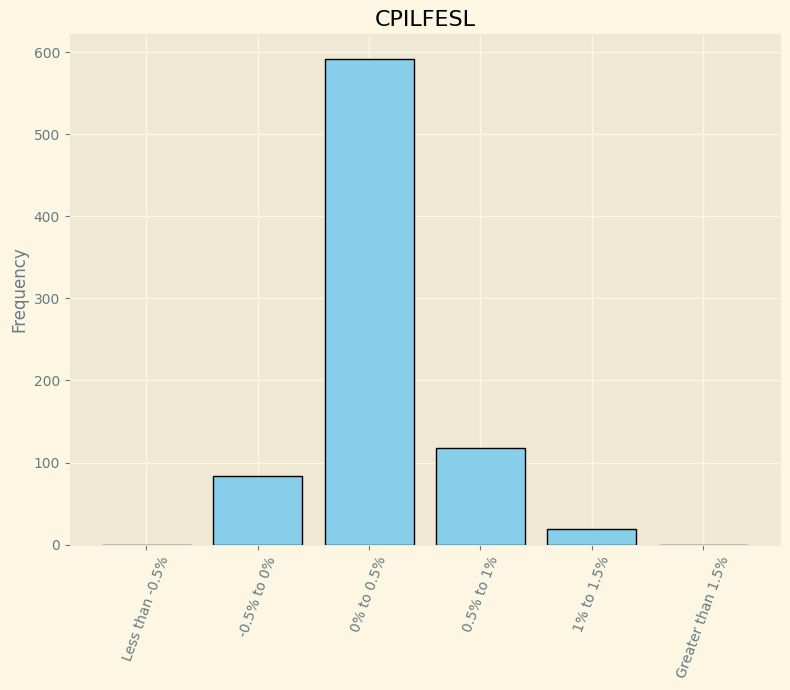

In [9]:
plt.figure(figsize=(8, 7))

plt.bar(occurrence_frequencies.index, occurrence_frequencies['Frequency'], color='skyblue', edgecolor='black')

# median_age = df['^ %'].median()
# plt.axvline(median_age, color='#fc4f30', label='Change Median')

# Add labels and title
plt.title('CPILFESL')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation=70) 
# Show the chart
plt.tight_layout()
plt.show();

- **Scatter plot**

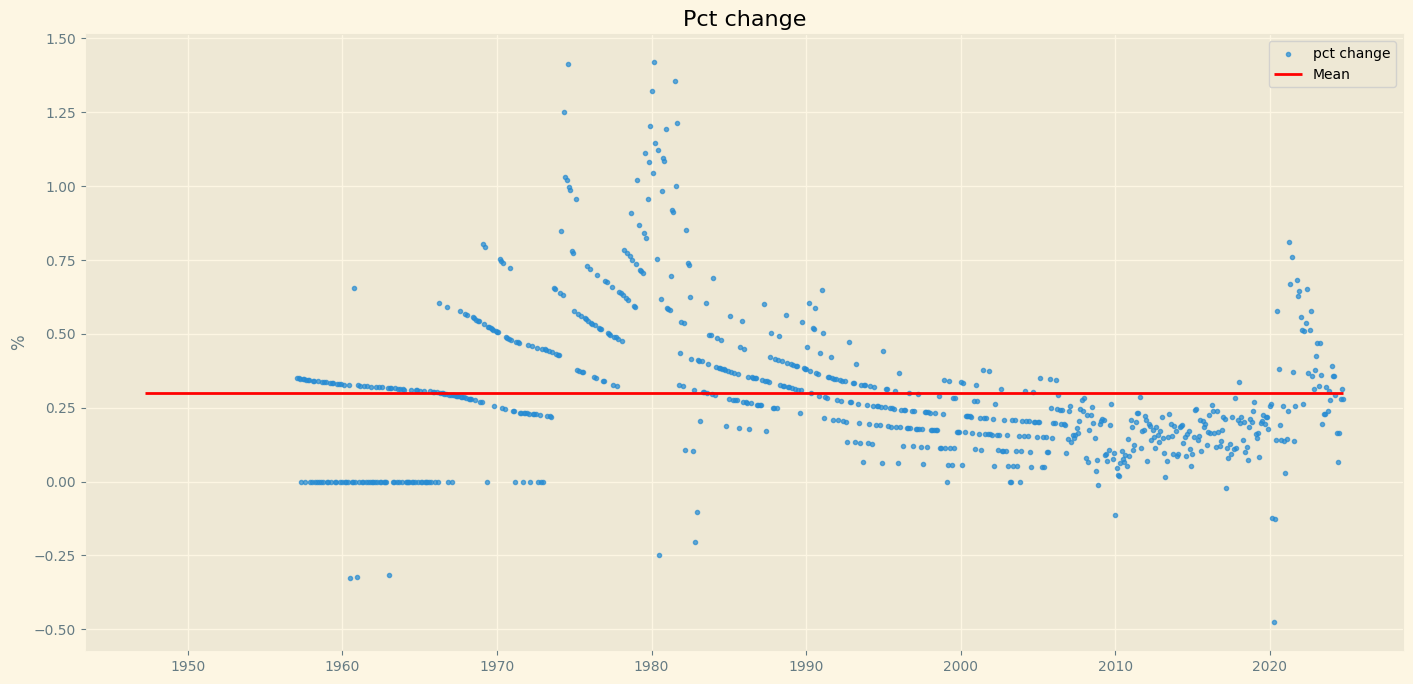

In [10]:
plt.figure(figsize=(17, 8))

plt.scatter(x=df.index, y=df['^ %']*100, alpha=.7, marker=".");
plt.plot(df.index, [100 * stats.mean] * len(df), 'r');
plt.title('Pct change')
plt.ylabel('%')
plt.legend(['pct change', 'Mean']);

- **CPI data**

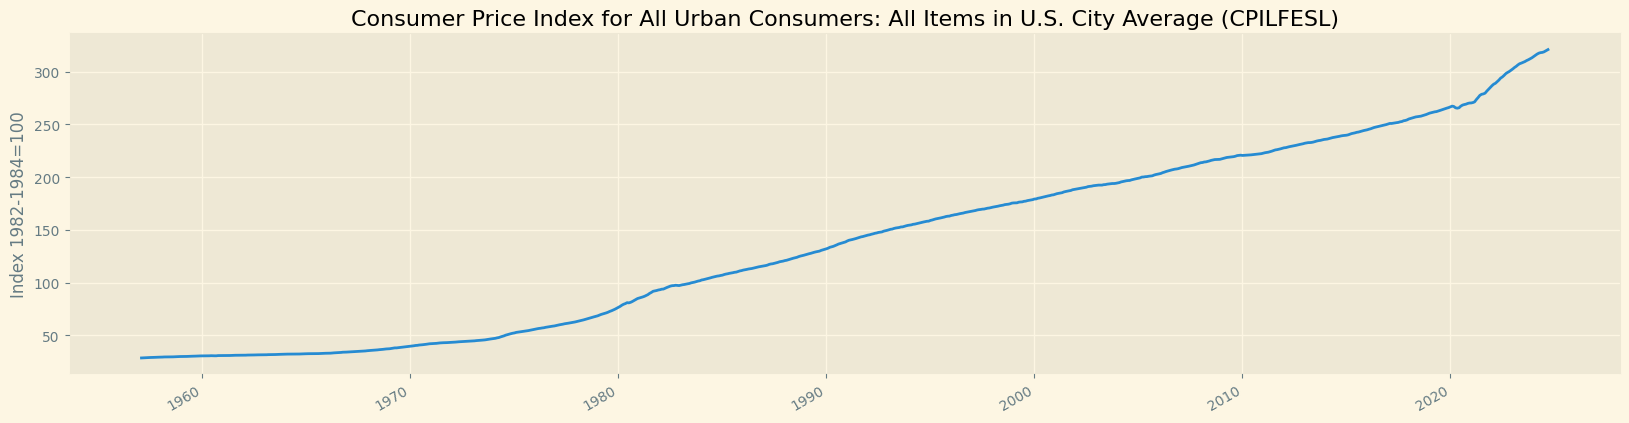

In [11]:
df['CPILFESL'].plot(
    figsize=(20, 5),
    xlabel='',
    ylabel='Index 1982-1984=100',
    title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPILFESL)',
);

In [12]:
# (df['^ %'] * 100).plot(
#     kind='bar',
#     figsize=(30, 10),
#     xlabel='',
#     ylabel='%',
#     title='CPI',
# );

# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# plt.xticks(rotation=70);

- **CPILFESL vs GDP Growth**

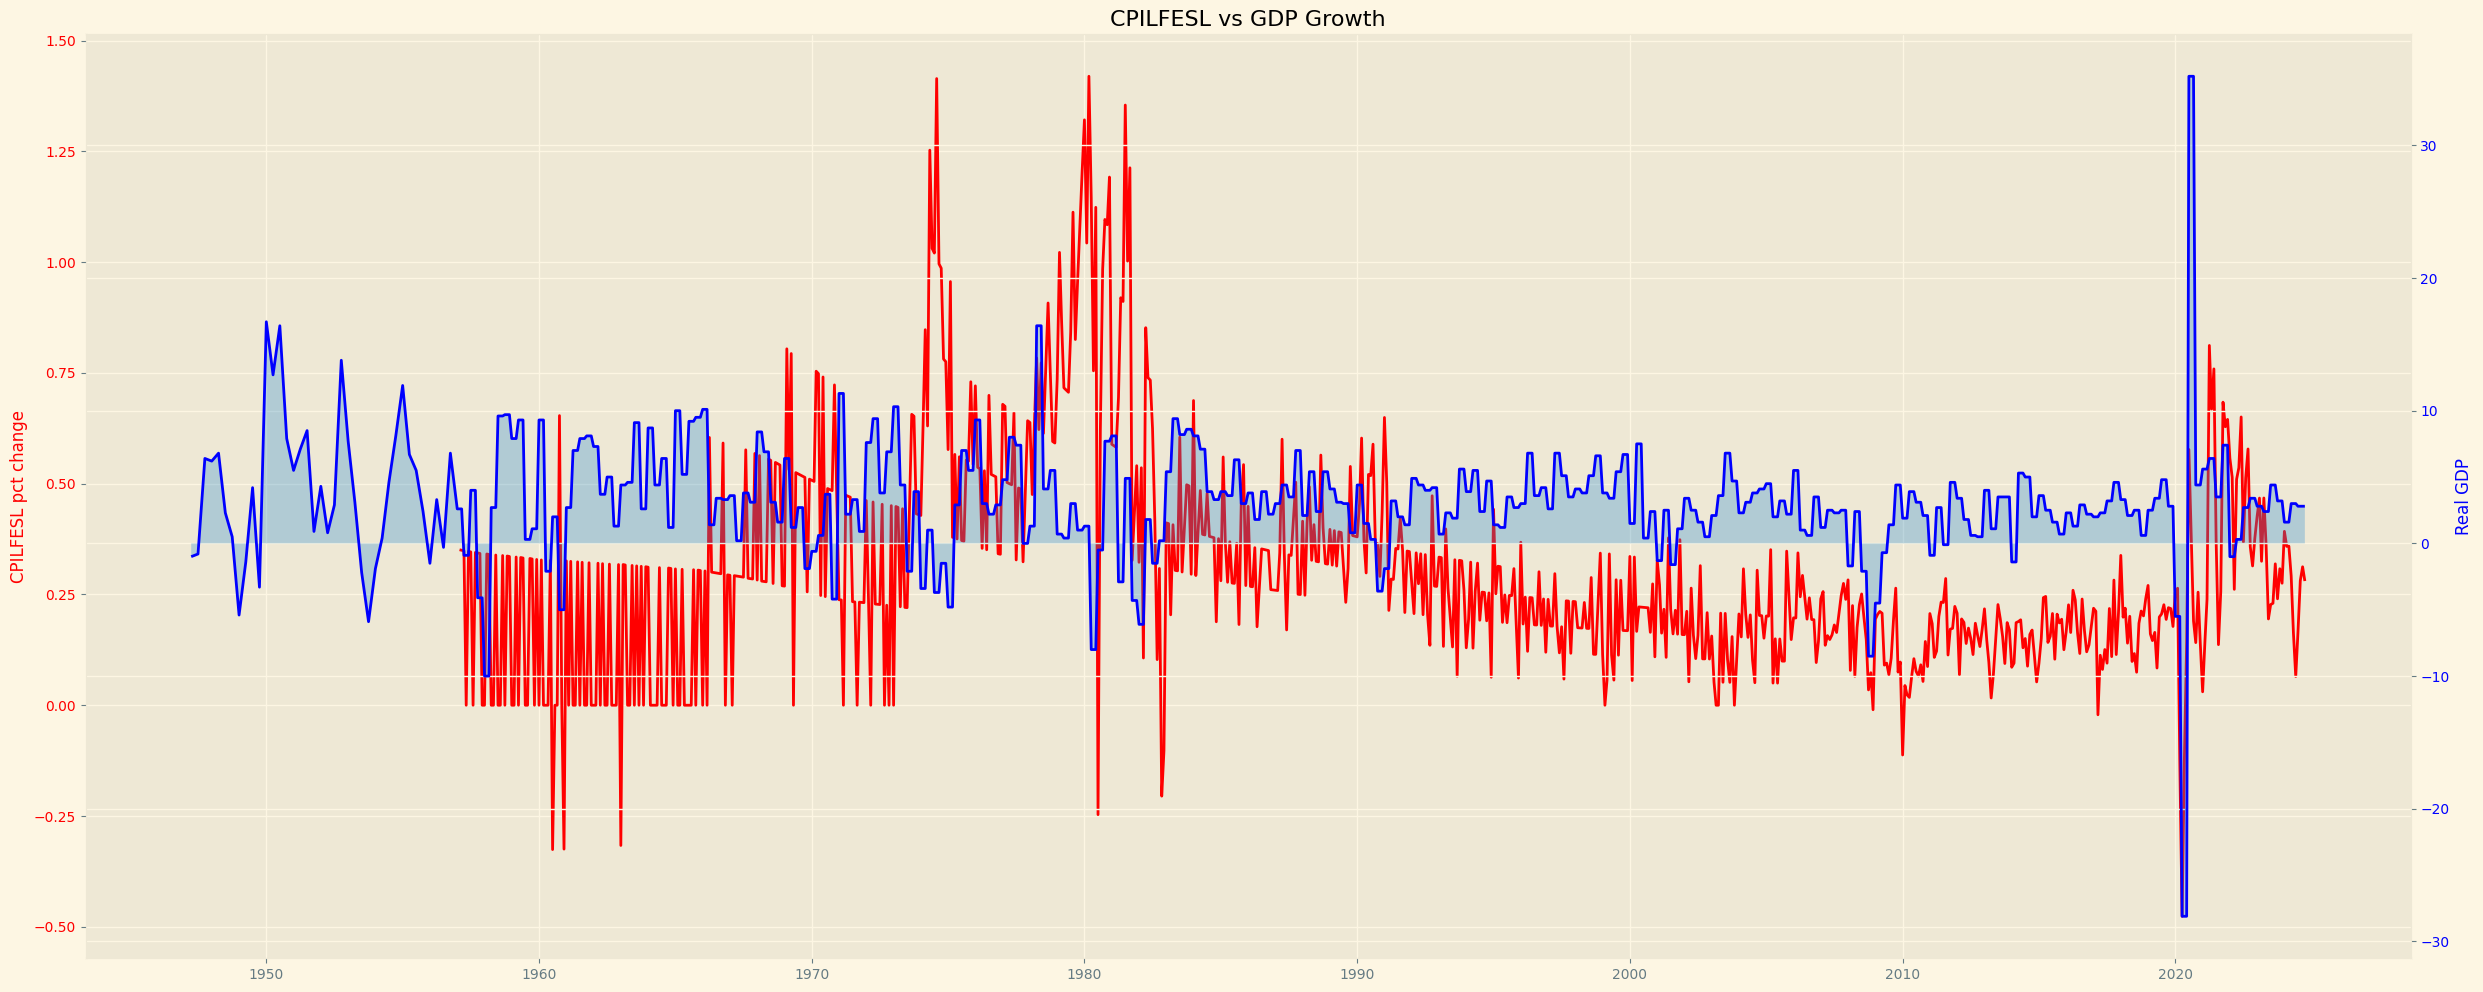

In [13]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(30, 12))

ax1.plot(df.index, df['^ %'] * 100, 'r-', label='CPILFESL pct change')
ax1.set_xlabel('')
ax1.set_ylabel('CPILFESL pct change', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()

ax2.plot(df.index, df['Real GDP'].ffill(), 'b-', label='Real GDP')
ax2.fill_between(df.index, df['Real GDP'].ffill(), alpha=.3, label='Real GDP')
ax2.set_ylabel('Real GDP', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.title('CPILFESL vs GDP Growth')
plt.show();


- **Last 10 years**

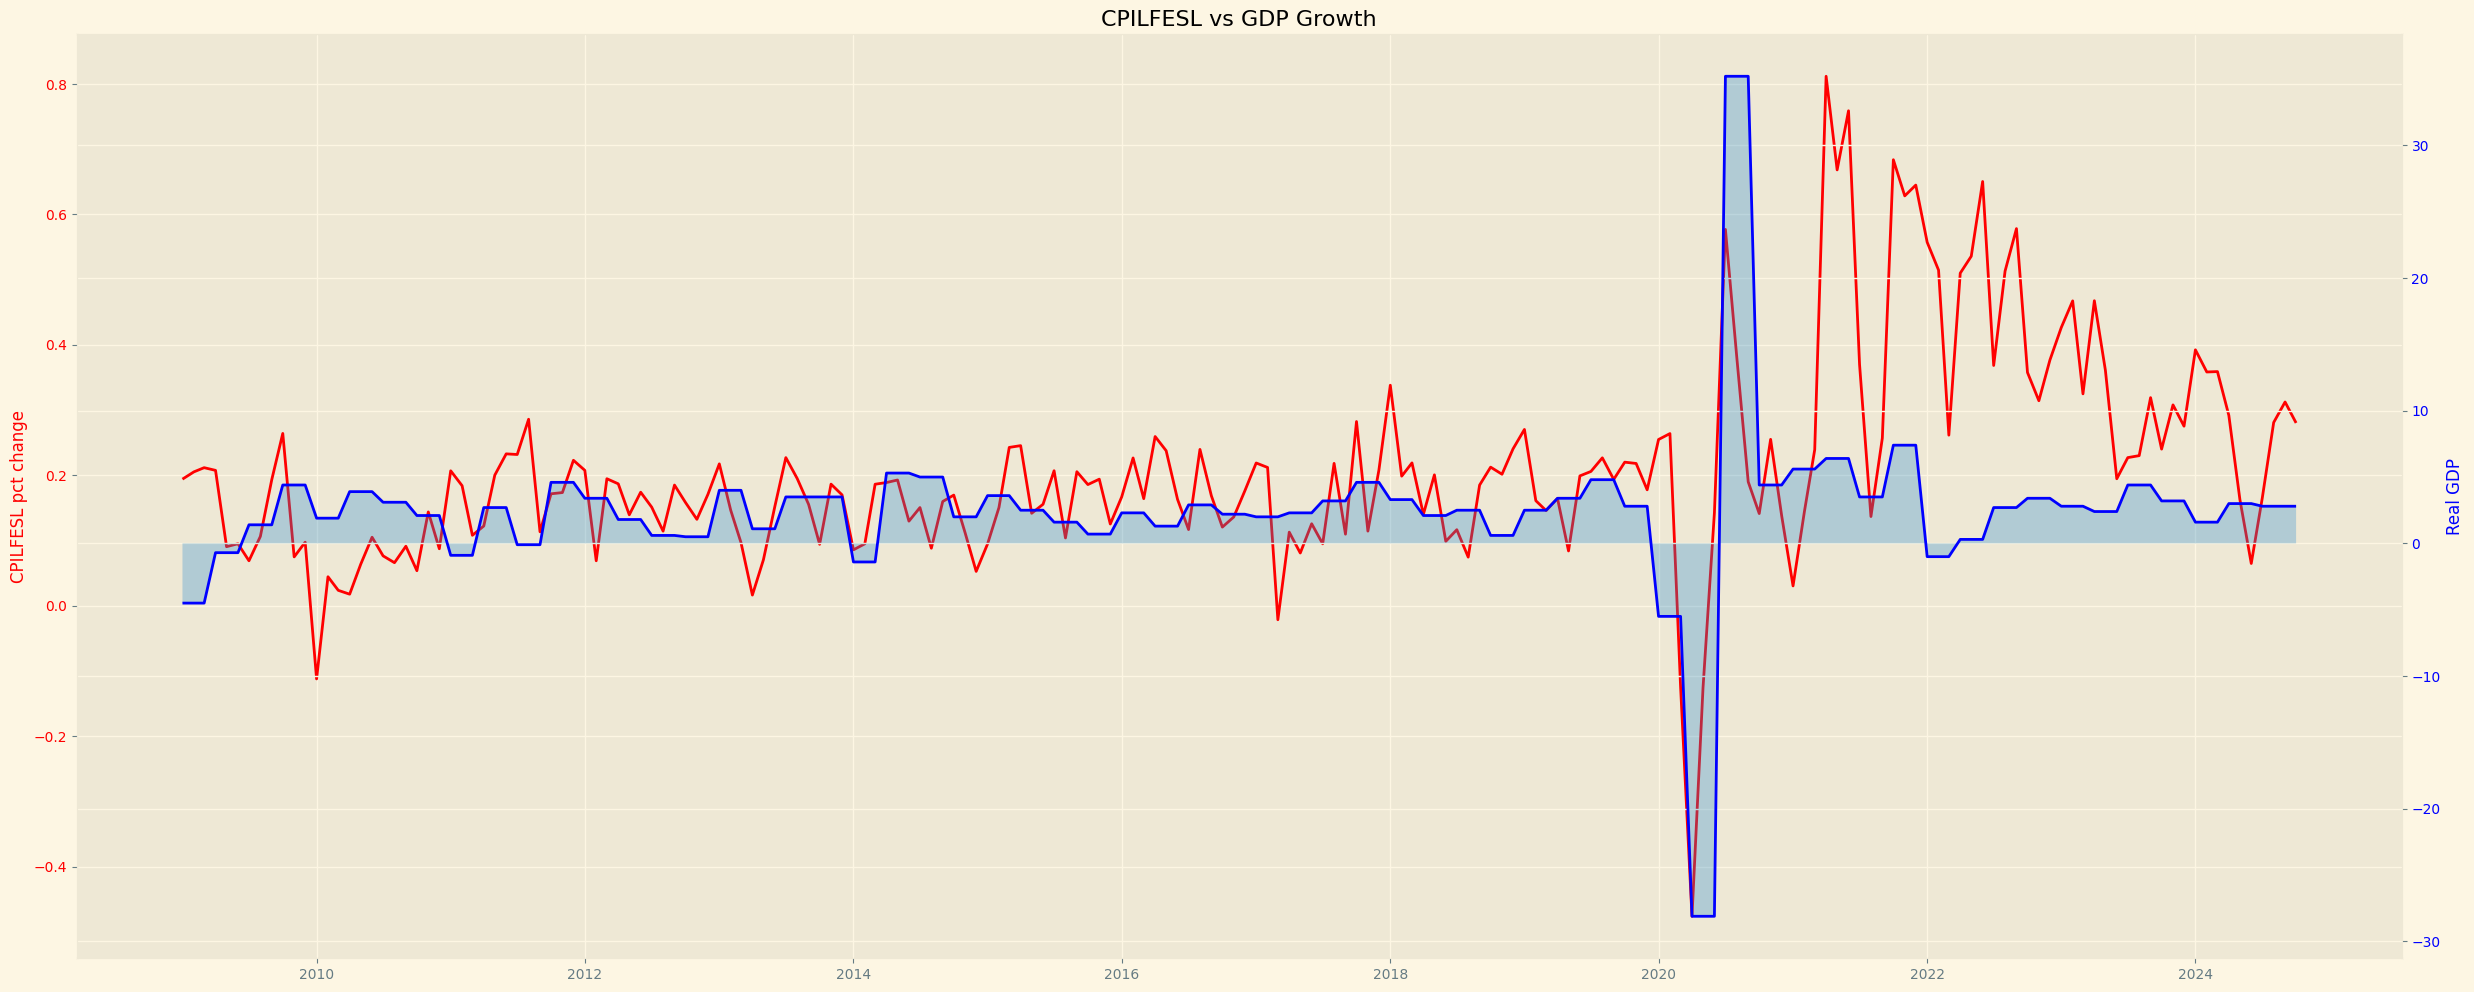

In [14]:
today = datetime.today()

last_10_years_df = df.loc[f"{today.year - 15}-01": f"{today.year}-{today.month}"]


fig, ax1 = plt.subplots(figsize=(30, 12))

ax1.plot(last_10_years_df.index, last_10_years_df['^ %'] * 100, 'r-', label='CPILFESL pct change')
ax1.set_xlabel('')
ax1.set_ylabel('CPILFESL pct change', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()

ax2.plot(last_10_years_df.index, last_10_years_df['Real GDP'].ffill(), 'b-', label='Real GDP')
ax2.fill_between(last_10_years_df.index, last_10_years_df['Real GDP'].ffill(), alpha=.3, label='Real GDP')
ax2.set_ylabel('Real GDP', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.title('CPILFESL vs GDP Growth')
plt.show();

---